## まとめ
* CNNはこれまでの全結合層のネットワークに対して、畳み込み層とプーリング層が新たに加わる
* 畳み込み層とプーリング層は、im2col（画像を行列に展開する関数）を用いるとシンプルで効率の良い実装ができる
* CNNの可視化によって、層が深くなるにつれて高度な情報が抽出されていく様子がわかる
* CNNの代表的なネットワークにはLeNetとAlexNetがある
* ディープラーニングの発展に、ビッグデータとGPUが大きく貢献している

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
ROOT_PATH='/content/drive/My Drive/Colab Notebooks/zero_DL/deep-learning-from-scratch/'
sys.path.append(ROOT_PATH)

Mounted at /content/drive


In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import time

## im2col

In [ ]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape   #input_data.shape(N,C,H,W)
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')    #H,Wに対してパディング
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))    #col.shape(N,C,FH,FW,H',W')
    print('col.shape\n',col.shape)

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
            print('\ncol\n',col)
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)    #col.shape(N,C,FH,FW,H',W')→transpose→(N,H',W',C,FH,FW)→reshape→(N*H'*W',C*FH*FW)
    return col

In [ ]:
input_data=np.random.randint(0,10,[2,2,3,3])
print('input_data=\n',input_data)
print(im2col(input_data,filter_h=2,filter_w=2,stride=1,pad=0))

input_data=
 [[[[0 3 0]
   [7 0 7]
   [1 8 2]]

  [[8 2 9]
   [0 6 8]
   [8 6 4]]]


 [[[5 0 9]
   [4 7 6]
   [3 1 9]]

  [[2 7 4]
   [9 9 4]
   [4 5 6]]]]
col.shape
 (2, 2, 2, 2, 2, 2)

col
 [[[[[[0. 3.]
     [7. 0.]]

    [[0. 0.]
     [0. 0.]]]


   [[[0. 0.]
     [0. 0.]]

    [[0. 0.]
     [0. 0.]]]]



  [[[[8. 2.]
     [0. 6.]]

    [[0. 0.]
     [0. 0.]]]


   [[[0. 0.]
     [0. 0.]]

    [[0. 0.]
     [0. 0.]]]]]




 [[[[[5. 0.]
     [4. 7.]]

    [[0. 0.]
     [0. 0.]]]


   [[[0. 0.]
     [0. 0.]]

    [[0. 0.]
     [0. 0.]]]]



  [[[[2. 7.]
     [9. 9.]]

    [[0. 0.]
     [0. 0.]]]


   [[[0. 0.]
     [0. 0.]]

    [[0. 0.]
     [0. 0.]]]]]]

col
 [[[[[[0. 3.]
     [7. 0.]]

    [[3. 0.]
     [0. 7.]]]


   [[[0. 0.]
     [0. 0.]]

    [[0. 0.]
     [0. 0.]]]]



  [[[[8. 2.]
     [0. 6.]]

    [[2. 9.]
     [6. 8.]]]


   [[[0. 0.]
     [0. 0.]]

    [[0. 0.]
     [0. 0.]]]]]




 [[[[[5. 0.]
     [4. 7.]]

    [[0. 9.]
     [7. 6.]]]


   [[[0. 0.]
     [0. 0.]]

    [

In [ ]:
#4重ループによるim2col(遅い)
def low_im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')

    col=np.zeros(filter_h*filter_w)
    for n in range(N):
      for y in range(out_h):
        y_max=y*stride
        for x in range(out_w):
          x_max=x*stride
          for c in range(C):
            c_row=img[n,c,y_max:y_max+filter_h,x_max:x_max+filter_w].flatten()
            col=np.vstack([col,c_row])
          
    col=np.delete(col,0,axis=0)
    col=col.reshape([N*out_h*out_w,C*filter_h*filter_w])
    return col

input_data=np.random.randint(0,10,[2,2,5,5])
print(input_data)
print(low_im2col(input_data,filter_h=3,filter_w=3,stride=2,pad=1))
print(im2col(input_data,filter_h=3,filter_w=3,stride=2,pad=1))

[[[[6 0 0 1 6]
   [7 1 8 8 5]
   [7 5 1 9 9]
   [7 0 5 4 6]
   [1 7 3 9 0]]

  [[1 4 4 7 5]
   [6 2 0 4 5]
   [0 2 5 3 7]
   [2 4 5 3 4]
   [8 0 8 1 3]]]


 [[[4 8 9 9 6]
   [8 3 7 6 4]
   [8 1 7 0 6]
   [9 2 7 1 3]
   [8 2 9 3 4]]

  [[3 2 8 1 9]
   [2 3 1 1 4]
   [2 8 1 6 2]
   [0 8 9 9 0]
   [8 5 9 6 9]]]]
[[0. 0. 0. 0. 6. 0. 0. 7. 1. 0. 0. 0. 0. 1. 4. 0. 6. 2.]
 [0. 0. 0. 0. 0. 1. 1. 8. 8. 0. 0. 0. 4. 4. 7. 2. 0. 4.]
 [0. 0. 0. 1. 6. 0. 8. 5. 0. 0. 0. 0. 7. 5. 0. 4. 5. 0.]
 [0. 7. 1. 0. 7. 5. 0. 7. 0. 0. 6. 2. 0. 0. 2. 0. 2. 4.]
 [1. 8. 8. 5. 1. 9. 0. 5. 4. 2. 0. 4. 2. 5. 3. 4. 5. 3.]
 [8. 5. 0. 9. 9. 0. 4. 6. 0. 4. 5. 0. 3. 7. 0. 3. 4. 0.]
 [0. 7. 0. 0. 1. 7. 0. 0. 0. 0. 2. 4. 0. 8. 0. 0. 0. 0.]
 [0. 5. 4. 7. 3. 9. 0. 0. 0. 4. 5. 3. 0. 8. 1. 0. 0. 0.]
 [4. 6. 0. 9. 0. 0. 0. 0. 0. 3. 4. 0. 1. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4. 8. 0. 8. 3. 0. 0. 0. 0. 3. 2. 0. 2. 3.]
 [0. 0. 0. 8. 9. 9. 3. 7. 6. 0. 0. 0. 2. 8. 1. 3. 1. 1.]
 [0. 0. 0. 9. 6. 0. 6. 4. 0. 0. 0. 0. 1. 9. 0. 1. 4. 0.]
 [0. 

In [ ]:
#im2colを使わないfilter掛け
input_data=np.random.randint(0,10,[2,2,5,5])  #N,C,H,W
filter=np.random.randint(0,10,[2,2,3,3])  #FN,C,FH,FW
print(filter)

N,C,H,W=input_data.shape
FN,C,FH,FW=filter.shape
stride=1
pad=0

out_h=int((H+2*pad-FH)/stride+1)
out_w=int((W+2*pad-FW)/stride+1)

img=np.pad(input_data,[(0,0),(0,0),(pad,pad),(pad,pad)],'constant')
print(img)
out=np.zeros([N,FN,out_h,out_w])

for n in range(N):
  for fn in range(FN):
    for y in range(out_h):
      y_max=y*stride+FH
      for x in range(out_w):
        x_max=x*stride+FW
        out[n,fn,y,x]=np.sum(img[n,:,y:y_max,x:x_max]*filter[fn,:])

print('out=\n',out)

#im2colによるinput_dataの展開
col=im2col(input_data,FH,FW,stride=stride,pad=pad)
#filterの展開
col_W=filter.reshape([FN,-1])
#im2colを使ったfilter掛け
col_out=np.dot(col,col_W.T)
col_out=col_out.reshape(N,out_h,out_w,FN)
col_out=col_out.transpose([0,3,1,2])

print('col_out=\n',col_out)
print(out==col_out)

[[[[8 1 4]
   [0 2 1]
   [0 6 2]]

  [[8 4 3]
   [9 0 3]
   [7 2 3]]]


 [[[9 7 2]
   [5 6 7]
   [0 0 1]]

  [[5 1 6]
   [3 3 0]
   [7 0 5]]]]
[[[[4 2 6 3 7]
   [8 3 0 3 6]
   [2 5 3 7 4]
   [1 7 5 6 4]
   [3 7 8 3 3]]

  [[2 9 7 4 5]
   [4 9 9 2 5]
   [9 7 0 1 2]
   [6 8 9 6 4]
   [8 7 7 2 6]]]


 [[[3 1 1 0 7]
   [9 9 0 2 1]
   [6 6 5 5 5]
   [1 4 7 9 4]
   [7 4 7 4 3]]

  [[2 6 3 3 5]
   [5 2 4 0 8]
   [2 0 1 3 6]
   [7 4 2 6 0]
   [7 9 4 1 8]]]]
out=
 [[[[313. 320. 332.]
   [393. 363. 277.]
   [382. 359. 261.]]

  [[286. 293. 265.]
   [377. 304. 285.]
   [334. 341. 313.]]]


 [[[216. 149. 223.]
   [280. 246. 192.]
   [294. 287. 227.]]

  [[214. 164. 144.]
   [368. 264. 204.]
   [309. 333. 346.]]]]
col_out=
 [[[[313. 320. 332.]
   [393. 363. 277.]
   [382. 359. 261.]]

  [[286. 293. 265.]
   [377. 304. 285.]
   [334. 341. 313.]]]


 [[[216. 149. 223.]
   [280. 246. 192.]
   [294. 287. 227.]]

  [[214. 164. 144.]
   [368. 264. 204.]
   [309. 333. 346.]]]]
[[[[ True  True  True]
   [ 

## col2im

In [ ]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## Convolution Layerの実装

In [5]:
class Convolution2:
  def __init__(self,W,b,stride=1,pad=0):
    self.W=W
    self.b=b
    self.stride=stride
    self.pad=pad

  def forward(self,x):
    FN,C,FH,FW=self.W.shape
    N,C,H,W=x.shape
    out_h=int((H+2*self.pad-FH)/self.stride+1)
    out_w=int((W+2*self.pad-FW)/self.stride+1)

    col=im2col(x,FH,FW,self.stride,self.pad)  #(N*H'*W',C*FH*FW)
    col_W=self.W.reshape(FN,-1).T #filterの展開と転置 (C*FH*FW,FN)
    out=np.dot(col,col_W)+self.b  #(N*H'*W',FN)

    #(N*H'*W',FN)→reshape→(N,H',W',FN)→transpose→(N,FN,H',W')
    out=out.reshape(N,out_h,out_w,-1).transpose(0,3,1,2)  

    self.col=col
    self.x=x
    self.col_W=col_W

    return out

  def backward(self,dout):
    FN,C,FH,FW=self.W.shape

    #(N,FN,H',W')→transpose→(N,H',W',FN)→reshape→(N*H'*W',FN)
    dout=dout.transpose(0,2,3,1).reshape(-1,FN)

    self.db=np.sum(dout,axis=0)

    #dot((C*FH*FW,N*H'*W'),(N*H'*W',FN))→(C*FH*FW,FN)
    self.dW=np.dot(self.col.T,dout)

    #(C*FH*FW,FN)→transpose→(FN,C*FH*FW)→reshape→(FN,C,FH,FW)
    self.dW=self.dW.transpose(1,0).reshape(FN,C,FH,FW)

    #dot((N*H'*W',FN),(FN,C*FH*FW))→(N*H'*W',C*FH*FW)
    dcol=np.dot(dout,self.col_W.T)

    #col2im(N*H'*W',C*FH*FW)→(N,C,H',W')
    dx=col2im(dcol,self.x.shape,FH,FW,stride=self.stride,pad=self.pad)

    return dx

## Pooling Layerの実装

In [6]:
class Pooling2:
  def __init__(self,pool_h,pool_w,stride=2,pad=0):
    self.pool_h=pool_h
    self.pool_w=pool_w
    self.stride=stride
    self.pad=pad

  def forward(self,x):
    N,C,H,W=x.shape
    out_h=int((H-self.pool_h)/self.stride+1)
    out_w=int((W-self.pool_w)/self.stride+1)

    #col2imによる展開 x.shape(N,C,H,W)→col.shape(N*H'*W',C*PH*PW)
    col=im2col(x,self.pool_h,self.pool_w,stride=self.stride,pad=self.pad)
    #(N*H'*W',C*PH*PW)→reshape→(N*H'*W'*C,PH*PW)
    col=col.reshape(-1,self.pool_h*self.pool_w)

    out=np.max(col,axis=1)  #(N*H'*W'*C,PH*PW)→max pooling→(N*H'*W'*C,1)
    arg_max=np.argmax(col,axis=1)

    #(N*H'*W'*C,1)→reshape→(N,H',W',C)→transpose→(N,C,H',W')
    out=out.reshape(N,out_h,out_w,C).transpose(0,3,1,2)

    self.x=x
    self.arg_max=arg_max

    return out

  def backward(self,dout):
    dout=dout.transpose(0,2,3,1)  #(N,C,H',W')→(N,H',W',C)
    pool_size=self.pool_h*self.pool_w
    dmax=np.zeros((dout.size,pool_size))  #(N*H'*W'*C,PH*PW)

    #最大値が入っていたインデックスにdoutの値を格納する（最大値以外は０)
    dmax[np.arange(self.arg_max.size),self.arg_max.flatten()]=dout.flatten()

    dmax=dmax.reshape(dout.shape+(pool_size,))  #(N,H',W',C)→(N,H',W',C,PH*PW)
    #↑タプルの結合をしている

    #(N,H',W',C,PH*PW)→(N*H'*W',C*PH*PW)
    dcol=dmax.reshape(dmax.shape[0]*dmax.shape[1]*dmax.shape[2],-1)
    
    dx=col2im(dcol,self.x.shape,self.pool_h,self.pool_w,stride=self.stride,pad=self.pad)

    return dx

In [ ]:
dout=np.random.randint(0,10,[2,5,5,2])
N,H,W,C=dout.shape
pool_size=4
dmax=np.zeros([N*H*W*C,pool_size])
dmax = dmax.reshape(dout.shape + (pool_size,))
print(dmax.shape)
dcol=dmax.reshape(dmax.shape[0]*dmax.shape[1]*dmax.shape[2],-1)
print(dcol.shape)

(2, 5, 5, 2, 4)
(50, 8)


In [3]:
from common.layers import *
from collections import OrderedDict

class SimpleConvNet2:
  def __init__(self,input_dim=(1,28,28),
               conv_param={'filter_num':30,'filter_size':5,'pad':0,'stride':1},
               hidden_size=100,output_size=10,weight_init_std=0.01):
    filter_num=conv_param['filter_num']
    filter_size=conv_param['filter_size']
    filter_pad=conv_param['pad']
    filter_stride=conv_param['stride']
    input_size=input_dim[1]
    conv_output_size=(input_size+2*filter_pad-filter_size)/filter_stride+1
    pool_output_size=int(filter_num*(conv_output_size/2)*(conv_output_size/2))

    self.params={}
    self.params['W1']=weight_init_std*np.random.randn(filter_num,
                                                       input_dim[0],filter_size,filter_size)
    self.params['b1']=np.zeros(filter_num)
    self.params['W2']=weight_init_std*np.random.randn(pool_output_size,hidden_size)
    self.params['b2']=np.zeros(hidden_size)
    self.params['W3']=weight_init_std*np.random.randn(hidden_size,output_size)
    self.params['b3']=np.zeros(output_size)

    self.layers=OrderedDict()
    self.layers['Conv1']=Convolution2(self.params['W1'],self.params['b1'],
                                     conv_param['stride'],conv_param['pad'])
    self.layers['Relu1']=Relu()
    self.layers['Pool1']=Pooling2(pool_h=2,pool_w=2,stride=2)
    self.layers['Affine1']=Affine(self.params['W2'],self.params['b2'])
    self.layers['Relu2']=Relu()
    self.layers['Affine2']=Affine(self.params['W3'],self.params['b3'])

    self.last_layer=SoftmaxWithLoss()

  def predict(self,x):
    for layer in self.layers.values():
      x=layer.forward(x)

    return x

  def loss(self,x,t):
    y=self.predict(x)
    loss=self.last_layer.forward(y,t)

    return loss

  def numerical_gradient(self, x, t):
    """勾配を求める（数値微分）

    Parameters
    ----------
    x : 入力データ
    t : 教師ラベル

    Returns
    -------
    各層の勾配を持ったディクショナリ変数
        grads['W1']、grads['W2']、...は各層の重み
        grads['b1']、grads['b2']、...は各層のバイアス
    """
    loss_w = lambda w: self.loss(x, t)

    grads = {}
    for idx in (1, 2, 3):
      grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
      grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

    return grads

  def gradient(self,x,t):
    #forward
    self.loss(x,t)

    #backward
    dout=1
    dout=self.last_layer.backward(dout)

    layers=list(self.layers.values())
    layers.reverse()

    for layer in layers:
      dout=layer.backward(dout)

    grads={}
    grads['W1']=self.layers['Conv1'].dW
    grads['b1']=self.layers['Conv1'].db
    grads['W2']=self.layers['Affine1'].dW
    grads['b2']=self.layers['Affine1'].db
    grads['W3']=self.layers['Affine2'].dW
    grads['b3']=self.layers['Affine2'].db

    return grads

  def accuracy(self, x, t, batch_size=100):
    if t.ndim != 1 : t = np.argmax(t, axis=1) #正解ラベルがone_hot表現の場合は１次元表記にする
        
    acc = 0.0
    for i in range(int(x.shape[0] / batch_size)):
      tx = x[i*batch_size:(i+1)*batch_size] #batch_size(0〜100まで)のデータ
      tt = t[i*batch_size:(i+1)*batch_size] #batch_size(0〜100まで)の正解ラベル
      y = self.predict(tx)
      y = np.argmax(y, axis=1)  #one_hot表記なので最大値のインデックスを取得する
      acc += np.sum(y == tt) 
  
    return acc / x.shape[0]

  def save_params(self, file_name="params.pkl"):
    params = {}
    for key, val in self.params.items():
      params[key] = val
    with open(file_name, 'wb') as f:
      pickle.dump(params, f)

  def load_params(self, file_name="params.pkl"):
    with open(file_name, 'rb') as f:
      params = pickle.load(f)
    for key, val in params.items():
      self.params[key] = val

    for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
      self.layers[key].W = self.params['W' + str(i+1)]
      self.layers[key].b = self.params['b' + str(i+1)]

In [ ]:
from dataset.mnist import load_mnist
from common.optimizer import *
from ch07.simple_convnet import SimpleConvNet

(x_train,t_train),(x_test,t_test)=load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs=20
lr=0.001

batch_size=100
train_size=x_train.shape[0]
iter_per_epoch=max(train_size/batch_size,1)
max_iter=int(max_epochs*iter_per_epoch)
evaluate_sample_num_per_epoch=1000
epoch_cnt=0

network1=SimpleConvNet2(input_dim=(1,28,28),
                       conv_param={'filter_num':30,'filter_size':11,'pad':0,'stride':1},
                       hidden_size=100,output_size=10,weight_init_std=0.01)

optimizer=Adam(lr)
train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

for i in range(max_iter):
  batch_mask=np.random.choice(train_size,batch_size)
  x_batch=x_train[batch_mask]
  t_batch=t_train[batch_mask]

  grads=network1.gradient(x_batch,t_batch)
  optimizer.update(network1.params,grads)

  loss=network1.loss(x_batch,t_batch)
  print('loss:'+str(loss))
  train_loss_list.append(loss)

  if i%iter_per_epoch==0:
    epoch_cnt+=1
    # t=evaluate_sample_num_per_epoch
    # x_train_sample,t_train_sample=x_train[:t],t_train[:t]
    # x_test_sample,t_test_sample=x_test[:t],t_test[:t]
    # train_acc=network1.accuracy(x_train_sample,t_train_sample)
    # test_acc=network1.accuracy(x_test_sample,t_test_sample)
    train_acc=network1.accuracy(x_batch,t_batch)
    test_acc=network1.accuracy(x_test,t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print('epoch:'+str(epoch_cnt)+' | train_acc:'+str(train_acc)+' test_acc:'+str(test_acc))

test_acc=network1.accuracy(x_test,t_test)
print('final_test_acc:'+str(test_acc))

loss:2.2991522932245245
epoch:1 | train_acc:0.39 test_acc:0.259
loss:2.295794971824497
loss:2.2900390992088298
loss:2.277349690020127
loss:2.266692017009184
loss:2.249356089815841
loss:2.215329608287237
loss:2.1806176855886226
loss:2.169993452296224
loss:2.100897334256063
loss:2.0554467882282235
loss:1.9683124543447155
loss:1.9579991893626494
loss:1.8871868963148477
loss:1.7791663678297747
loss:1.7170928014949443
loss:1.6789079714931694
loss:1.525278197610811
loss:1.4304152217336046
loss:1.3419362166559958
loss:1.3400754120002034
loss:1.2836213077130731
loss:1.030233176152408
loss:1.0957032371179192
loss:0.9486904462971026
loss:1.0116591303304385
loss:0.8314533951300187
loss:0.8482263624250486
loss:0.8273707287618616
loss:0.7135680330917215
loss:0.7778277684979813
loss:0.6587312735424519
loss:0.6081396787431824
loss:0.7767809628147455
loss:0.6242006342610986
loss:0.6084082706119199
loss:0.6026162112172925
loss:0.6768751982482357
loss:0.4557426010625413
loss:0.7392670279474589
loss:0.66

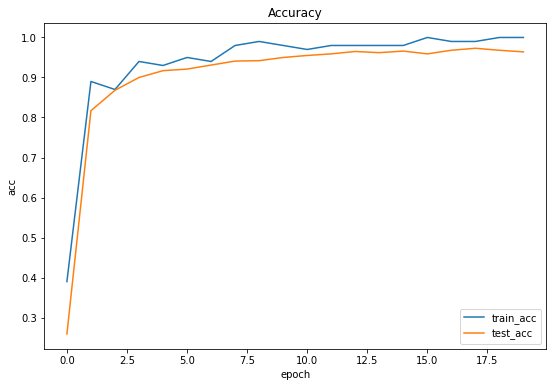

In [ ]:
epoch=np.arange(max_epochs)

plt.figure(figsize=(9,6),facecolor='w')
plt.plot(epoch,train_acc_list,label='train_acc')
plt.plot(epoch,test_acc_list,label='test_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.show()

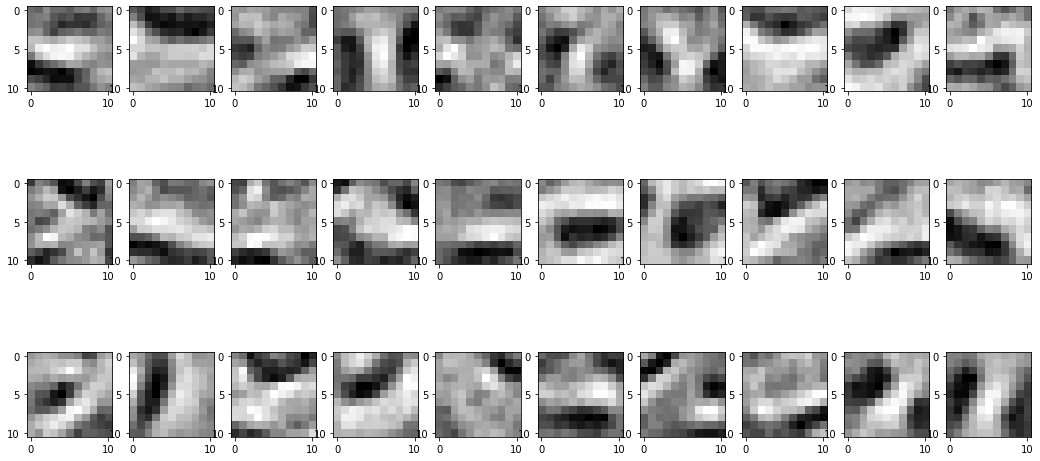

In [ ]:
#学習済みのフィルターを確認
plt.figure(facecolor='w',figsize=(18,9))
plt.gray()
for i in range(network1.params['W1'].shape[0]):
  img=network1.params['W1'][i,0,:]
  plt.subplot(3,10,i+1)
  plt.imshow(img)
plt.show()